## Waterhackweek cyberseminar
# Workflows for gridded climate datasets
## Diana Gergel and Bart Nijssen
### University of Washington
### February 14, 2019

**Abstract:** Climate change, forecasting, satellite datasets, large model ensembles ... Large gridded datasets are everywhere in hydrology and earth science. While accessing and analyzing these datasets required some serious programming skills not so long ago, a number of toolkits are now available that let you easily access, ingest, analyze and display gridded climate datasets. In this webinar we’ll discuss one of the most common file formats used in our field for large data sets, the Network Common Data Format (NetCDF), and step through a Jupyter notebook to showcase python packages, such as xarray and cartopy, that can be used to examine them. No prior experience required, although we will build on some of the skills you have acquired in earlier webinars in the series.

## GitHub repository

The GitHub repository for this presentation can be found at: https://github.com/bartnijssen/gridded_data

The README.md file in this repository explains how to configure the environment you need to run the sample notebooks.

## Outline

* `gridded_data_1_background.ipynb`


* `gridded_data_2_xarray_and_dask.ipynb`


* `gridded_data_3_cartopy_and_seaborn.ipynb`


* `gridded_data_4_rasterio.ipynb` (this notebook)
    + Opening and displaying a GeoTIFF using rasterio


## Other data formats

Clearly there are many standardized data formats other than NetCDF, even though that is the file format we tend to use most commonly in our line of research. Fortunately the community contributing to python is large and you will be able to find tools to access most common (and many uncommon) data formats. If you can't find one, maybe you can provide such a package to the rest of the python community or perhaps you should seriously consider using a more widely shared data format to store your data. 

## rasterio

In this last notebook we will very briefly show one other python package commonly used to access data files that are commonly used in the GIS and geospatial communities. These are data files that also include some metadata, in particular projection information that maps each data point in the file to a geospatial location.

As a caveat - I hardly ever work with these files and for the following commands I borrow heavily from the rasterio documentation at https://rasterio.readthedocs.io/ and from an earlier geohackweek tutorial on working with raster datasets at https://geohackweek.github.io/raster/04-workingwithrasters/. Please look there if you want more information.

Here, we will limit ourselves at opening, querying and displaying some geotiff files and showcasing a few features of rasterio.

rasterio is built on [GDAL](https://gdal.org/), the Geospatial Data Abstraction Library, which is a translator library for raster and vector geospatial data formats. There are command-line utilities that are built on this library as well as python bindings, but they can be difficult to use. rasterio's goal is to bring all of GDAL's raster functionality cleanly into python, while performing as fast as GDAL’s Python bindings. It reads raster files and returns them as Numpy arrays, which can then be manipulated by other python code. Note that rasterio also has a set of command-line utilities. 

Basically, rasterio will make it easy to read and write geo-registered files. Computations that are done on the data you read can be done with other python libraries such as numpy or even xarray as we will see at the end of this notebook.

## Opening a dataset

In this example, we will use rasterio to read some Geotiff files. Geotiff is a common format in GIS applications, because it allows georeferencing information to be embedded within a TIFF file. For example, orthorectified aerial photos and satellite images are often distributed in GeoTIFF format. 

Here we will take advantage of rasterio to directly read data from a URL. 

First we import rasterio:

In [1]:
import rasterio

and then define the URL we want to read. In this case, we will read from a landsat image stored on AWS (note that this is the image used in the [geohackweek tutorial](https://geohackweek.github.io/raster/04-workingwithrasters/)):

In [73]:
image_url = 'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'

This is a landsat-8 image from path 42, row 34, taken in June 2017. 'T1' stands for 'Tier 1' (for analytic use) and 'B4' stands for 'Band 4', which indicates a specific wavelength band.

We can use raterio to read the image metadata, without downloading the entire image (remote sensing images can be large):

In [77]:
with rasterio.open(image_url) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7821, 'height': 7951, 'count': 1, 'crs': CRS.from_dict(init='epsg:32611'), 'transform': Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


This is a bit hard on the eyes, so let's format it a bit better

In [78]:
with rasterio.open(image_url) as src:
    for key, value in src.profile.items():
        print("{} : {}".format(key, value))

driver : GTiff
dtype : uint16
nodata : None
width : 7821
height : 7951
count : 1
crs : EPSG:32611
transform : | 30.00, 0.00, 204285.00|
| 0.00,-30.00, 4268115.00|
| 0.00, 0.00, 1.00|
blockxsize : 512
blockysize : 512
tiled : True
compress : deflate
interleave : band


So `src.profile` is a collection of metadata for the file. We see that it is a Geotiff (Gtiff), the image values are unsigned integer format, nodata values are not assigned, the image has a dimensions of 7711x7531, is a single band, is in UTM coordinates, has a simple affine transformation, is chunked into smaller 512x512 arrays, tiled and compressed on the AWS hard drive where it is stored.

As an aside: The `with` construction is commonly used in python (see [here](https://docs.python.org/3/reference/compound_stmts.html#the-with-statement)) for more detail. The advantage of using it with file access is that the file is automatically closed at the end of the block, even if the block fails. So when you do:

In [83]:
with rasterio.open(image_url) as src:
    print('In block\t: {}'.format(src))
print('After block\t: {}'.format(src))

In block	: <open DatasetReader name='http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF' mode='r'>
After block	: <closed DatasetReader name='http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF' mode='r'>


You see that `src` is an `open DatasetReader` within the `with` block and a `closed DatasetReader` after the block, even though we never closed the reader explicitly. That is often very useful, but not so much in this case, so we will just open `image_url` without the `with` block:

In [89]:
src = rasterio.open(image_url)

We can then quickly see what all the elements are in `src`:

In [90]:
dir(src)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_block_shapes',
 '_closed',
 '_count',
 '_crs',
 '_crs_wkt',
 '_descriptions',
 '_dtypes',
 '_env',
 '_gcps',
 '_get_crs',
 '_handle_crswkt',
 '_has_band',
 '_mask_flags',
 '_nodatavals',
 '_offsets',
 '_read',
 '_scales',
 '_set_all_descriptions',
 '_set_all_offsets',
 '_set_all_scales',
 '_set_all_units',
 '_set_attrs_from_dataset_handle',
 '_set_crs',
 '_set_gcps',
 '_set_nodatavals',
 '_transform',
 '_units',
 'block_shapes',
 'block_size',
 'block_window',
 'block_windows',
 'bounds',
 'checksum',
 'close',
 'closed',
 'colorinterp',
 'colormap',
 'compr

To read the actual data from `src`, we would use `src.read(n)`, where `n` is the band we want to read. Since this dataset has only one band (Band 4), we would use

In [95]:
data = src.read(1)

We can inspect the data type of `data`

In [96]:
type(data)

numpy.ndarray

and see that this is now a `numpy ndarray` or n-dimensional array. You can now do computations on this like on any other numpy array. 

To get a quick overview of the content of the file itself, we can use rasterio's plot functionality

In [ ]:
import rasterio.plot

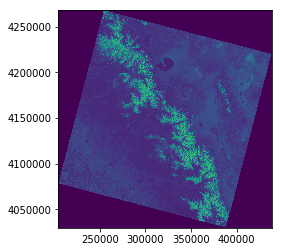

In [97]:
rasterio.plot.show(src)

Note that the x and y-labels in this case are actually georeferenced coordinates, rather than just image and line numbers. If you would plot the data contained in the file using `matplotlib`

In [98]:
import matplotlib.pyplot as plt

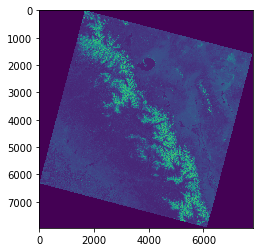

In [99]:
plt.imshow(data)

you get the same image, but the georeferencing is lost. We'll leave it as an exercise for you how to plot this data using `cartopy`. Take a look at the [geohackweek tutorial](https://geohackweek.github.io/raster/04-workingwithrasters/) to see how you can subset the image, generate thumbnails, or combine multiple bands to calculate the normalized vegetation difference index (NDVI).

## xarray and rasterio

Lastly, in python there are often many ways to do the same thing. For example, having seen some of the `xarray` functionality, you may wonder how you can convert the data you read with rasterio into `xarray`. An experimental interface exists to read files that rasterio can read directly into `xarray` as a `DataArray`:

In [101]:
import xarray as xr

In [102]:
da = xr.open_rasterio(image_url, parse_coordinates=True, chunks=None, cache=None, lock=None)

In [118]:
da

<xarray.DataArray (band: 1, y: 7951, x: 7821)>
[62184771 values with dtype=uint16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.268e+06 4.268e+06 4.268e+06 ... 4.03e+06 4.03e+06
  * x        (x) float64 2.043e+05 2.043e+05 2.044e+05 ... 4.389e+05 4.389e+05
Attributes:
    transform:   (30.0, 0.0, 204285.0, 0.0, -30.0, 4268115.0)
    crs:         EPSG:32611
    res:         (30.0, 30.0)
    is_tiled:    1
    nodatavals:  (nan,)

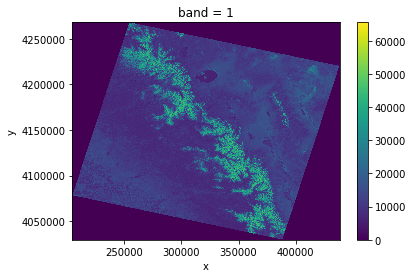

In [120]:
da[0].plot.imshow()